In [ ]:
!pip install catboost joblib scikit-learn pandas numpy

# ================= НАСТРОЙКИ =================
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import math

DATA_PATH = "ch_rifles.csv"
MODEL_CBM_PATH = "ch_guns_model.cbm"
WRAPPER_PKL_PATH = "ch_guns_wrapper.pkl"
TARGET_COL = "price"

# ================= ПРИЗНАКИ =================
BASE_NUM_FEATURES = [
    "float", "pattern", "stattrak",
    "backside_blue", "playside_blue",
    "stickers_count", "stickers_total_value", "stickers_avg_value", "stickers_max_value",
    "slot0_price", "slot1_price", "slot2_price", "slot3_price"
]
ENGINEERED_NUM_FEATURES = ["blue_score", "blue_tier"]
NUM_FEATURES = BASE_NUM_FEATURES + ENGINEERED_NUM_FEATURES
CAT_FEATURES = ["weapon", "skin", "wear", "pattern_style"]

# ================= 1. ЗАГРУЗКА =================
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

for col in BASE_NUM_FEATURES + ["weapon", "skin", "wear", TARGET_COL]:
    if col not in df.columns:
        raise ValueError(f"Нет колонки: {col}")

# ================= 2. ENGINEERED-ФИЧИ =================
def add_pattern_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[["playside_blue", "backside_blue"]] = df[["playside_blue", "backside_blue"]].fillna(0.0)
    df["blue_score"] = 0.7*df["playside_blue"] + 0.3*df["backside_blue"]

    def to_tier_blue(x):
        return 3 if x>=60 else 2 if x>=35 else 1 if x>=15 else 0
    df["blue_tier"] = df["playside_blue"].apply(to_tier_blue)

    def pattern_style(row):
        pb = row["playside_blue"]
        if pb >= 60: return "blue_gem"
        if pb >= 30: return "blue_mix"
        return "other"

    df["pattern_style"] = df.apply(pattern_style, axis=1)
    return df

df = add_pattern_features(df)

# ================= 3. ПРЕПРОЦЕССИНГ =================
df[NUM_FEATURES] = df[NUM_FEATURES].fillna(0.0)
for col in CAT_FEATURES:
    df[col] = df[col].fillna("unknown").astype(str)
df = df[df[TARGET_COL].notna() & (df[TARGET_COL]>0)]

# ================= 4. TRAIN / TEST =================
X = df[NUM_FEATURES + CAT_FEATURES]
y = df[TARGET_COL].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]

train_pool = Pool(X_train, y_train, cat_features=cat_indices)
test_pool  = Pool(X_test, y_test, cat_features=cat_indices)

# ================= 5. ОБУЧЕНИЕ =================
model = CatBoostRegressor(
    depth=8, learning_rate=0.05, loss_function="RMSE",
    eval_metric="RMSE", iterations=1500, random_seed=42,
    od_type="Iter", od_wait=120, verbose=100
)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# ================= 6. МЕТРИКИ =================
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# ================= 7. СОХРАНЕНИЕ МОДЕЛИ =================
model.save_model(MODEL_CBM_PATH)
wrapper_data = {
    "base_num_features": BASE_NUM_FEATURES,
    "engineered_num_features": ENGINEERED_NUM_FEATURES,
    "num_features": NUM_FEATURES,
    "cat_features": CAT_FEATURES
}
joblib.dump(wrapper_data, WRAPPER_PKL_PATH)
print(f"[✓] Модель сохранена: {MODEL_CBM_PATH}")
print(f"[✓] Метаданные сохранены: {WRAPPER_PKL_PATH}")

# ================= 8. ФУНКЦИИ ЗАГРУЗКИ И ПРЕДСКАЗАНИЯ =================
def load_ch_model(cbm_path=MODEL_CBM_PATH, wrapper_path=WRAPPER_PKL_PATH):
    model = CatBoostRegressor()
    model.load_model(cbm_path)
    wrapper_data = joblib.load(wrapper_path)
    return model, wrapper_data

def prepare(df: pd.DataFrame, wrapper_data):
    df = df.copy()
    for col in wrapper_data["num_features"]:
        if col not in df.columns: df[col] = 0.0
    for col in wrapper_data["cat_features"]:
        if col not in df.columns: df[col] = "unknown"

    df["blue_score"] = 0.7*df.get("playside_blue",0) + 0.3*df.get("backside_blue",0)
    df["blue_tier"] = df.get("playside_blue",0).apply(lambda x: 3 if x>=60 else 2 if x>=35 else 1 if x>=15 else 0)
    df["pattern_style"] = df.apply(lambda row: (
        "blue_gem" if row.get("playside_blue",0)>=60 else
        "blue_mix" if row.get("playside_blue",0)>=30 else
        "other"
    ), axis=1)

    return df[wrapper_data["num_features"] + wrapper_data["cat_features"]]

def predict_one(model, wrapper_data, **kwargs):
    df = pd.DataFrame([kwargs])
    df_prep = prepare(df, wrapper_data)
    return float(model.predict(df_prep)[0])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
0:	learn: 3111.4461746	test: 4303.5168186	best: 4303.5168186 (0)	total: 77.2ms	remaining: 1m 55s
100:	learn: 1986.1251585	test: 3847.6393340	best: 3847.6393340 (100)	total: 2.43s	remaining: 33.7s
200:	learn: 1491.2837386	test: 3511.4461757	best: 3511.4461757 (200)	total: 6.25s	remaining: 40.4s
300:	learn: 1040.8793099	test: 3116.6946423	best: 3116.6946423 (300)	total: 8.49s	remaining: 33.8s
400:	learn: 804.9485501	test: 2935.5392597	best: 2935.5392597 (400)	total: 10.8s	remaining: 29.6s
500:	learn: 683.5748589	test: 2847.8718458	best: 2847.8718458 (500)	total: 13.2s	remaining: 26.3s
600:	learn: 614.8244160	test: 2818.7914826	best: 2818.7914826 (600)	total: 16.2s	remaining: 24.2s
700:	learn: 550.7171139	test: 2781.2095999	best: 2781.2095999 (700)	total: 20.2s	remaining: 23.1s
800:	learn: 504.1091721	test: 2756.6430512	best: 2756.6430512 (800)	total: 22.7s	remaining: 19.8s
900:	learn: 467.1489408	test: 2738.558

In [1]:
!pip install -q catboost pandas scikit-learn joblib shap optuna wandb seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 25.4 MB/s eta 0:00:00


#Импорты и настройки

In [2]:
import math
import time

import pandas as pd
import numpy as np

import joblib
import shap
import optuna
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 42

DATA_PATH = "fade_rifles.csv"
TARGET_COL = "price"

NUM_FEATURES = [
    "float",
    "pattern",
    "stattrak",

    "fade_percentage",
    "fade_rank",

    "stickers_count",
    "stickers_total_value",
    "stickers_avg_value",
    "stickers_max_value",

    "slot0_price",
    "slot1_price",
    "slot2_price",
    "slot3_price",
]

CAT_FEATURES = [
    "weapon",
    "skin",
    "wear",
]

ALL_FEATURES = NUM_FEATURES + CAT_FEATURES


#EDA

Размер датасета: (2553, 26)


,weapon,skin,wear,float,pattern,stattrak,price,phase,fade_seed,fade_percentage,...,stickers_total_over_price,slot0_name,slot0_price,slot1_name,slot1_price,slot2_name,slot2_price,slot3_name,slot3_price,market_hash_name
0,AWP,Fade,Factory New,0.001899,683,0,1390.76,NaN,683,98.64601,...,0.353512,Sticker | Great Wave (Holo),18.32,Sticker | Great Wave (Holo),18.32,Sticker | Great Wave (Holo),18.32,Sticker | Crown (Foil),436.69,AWP | Fade (Factory New)
1,AWP,Fade,Factory New,0.007378,683,0,1021.24,NaN,683,98.64601,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AWP | Fade (Factory New)
2,AWP,Fade,Factory New,0.009071,683,0,1047.80,NaN,683,98.64601,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AWP | Fade (Factory New)
3,AWP,Fade,Factory New,0.007378,683,0,1021.24,NaN,683,98.64601,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AWP | Fade (Factory New)
4,AWP,Fade,Factory New,0.009071,683,0,1047.80,NaN,683,98.64601,...,0.000000,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,AWP | Fade (Factory New)



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   weapon                     2553 non-null   object 
 1   skin                       2553 non-null   object 
 2   wear                       2553 non-null   object 
 3   float                      2553 non-null   float64
 4   pattern                    2553 non-null   int64  
 5   stattrak                   2553 non-null   int64  
 6   price                      2553 non-null   float64
 7   phase                      0 non-null      float64
 8   fade_seed                  2553 non-null   int64  
 9   fade_percentage            2553 non-null   float64
 10  fade_rank                  2553 non-null   int64  
 11  fade_type                  2553 non-null   object 
 12  stickers_count             2553 non-null   int64  
 13  stickers_total_value

,float,pattern,stattrak,fade_percentage,fade_rank,stickers_count,stickers_total_value,stickers_avg_value,stickers_max_value,slot0_price,slot1_price,slot2_price,slot3_price,price
count,2553.000000,2553.000000,2553.0,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000
mean,0.023905,488.715629,0.0,92.123106,382.667450,0.454759,281.274458,167.057932,246.432378,231.900035,17.772096,15.901900,14.281876,1495.243999
std,0.018918,285.750133,0.0,6.294051,307.707845,1.227465,4212.754156,2740.636011,4117.737744,4103.109336,314.443875,292.673717,208.389000,3718.884113
min,0.000000,0.000000,0.0,80.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.090000
25%,0.009780,237.000000,0.0,86.574030,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,644.490000
50%,0.020185,493.000000,0.0,93.667305,312.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,943.230000
75%,0.032694,739.000000,0.0,98.081910,639.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1422.380000
max,0.087191,998.000000,0.0,100.000000,1001.000000,5.000000,142464.940000,72420.530000,141149.230000,141149.230000,12960.580000,11773.550000,6120.950000,100000.000000



Количество пропусков:


,0
phase,2553
slot3_name,2366
slot2_name,2328
slot1_name,2282
slot0_name,2156
float,0
skin,0
wear,0
pattern,0
weapon,0


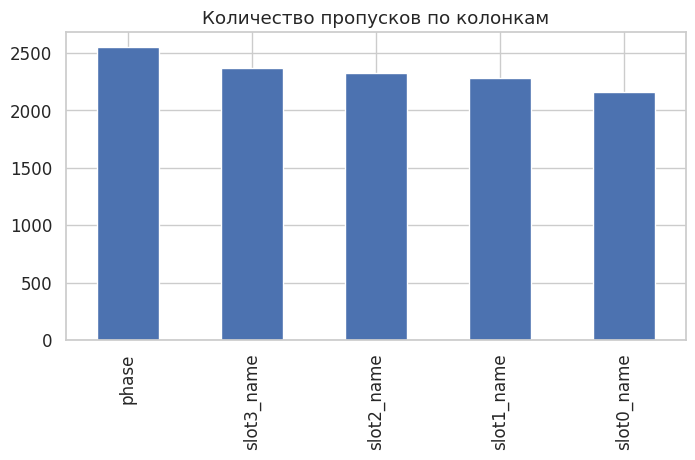

In [3]:
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

print("Размер датасета:", df.shape)
display(df.head())

print("\nИнформация о типах данных:")
df.info()

print("\nСтатистика по числовым колонкам:")
display(df[NUM_FEATURES + [TARGET_COL]].describe())

missing = df.isnull().sum().sort_values(ascending=False)
print("\nКоличество пропусков:")
display(missing)

plt.figure(figsize=(8, 4))
missing[missing > 0].plot(kind="bar")
plt.title("Количество пропусков по колонкам")
plt.show()


### Структура датасета fade_rifles

- Целевой признак: `price` — цена rifle с градиентом Fade.
- Числовые признаки:
  - `float`, `pattern`, `stattrak`;
  - параметры фейда: `fade_percentage`, `fade_rank`;
  - агрегаты по наклейкам: `stickers_*`, `slot*_price`.
- Категориальные признаки:
  - `weapon`, `skin`, `wear`.

График пропусков показывает, в каких колонках есть NaN — они позже заполняются
(0.0 для чисел, "unknown" для категорий).


## Распределение цены

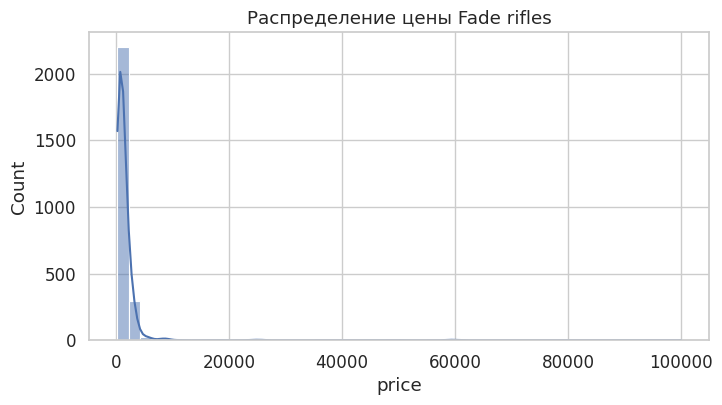

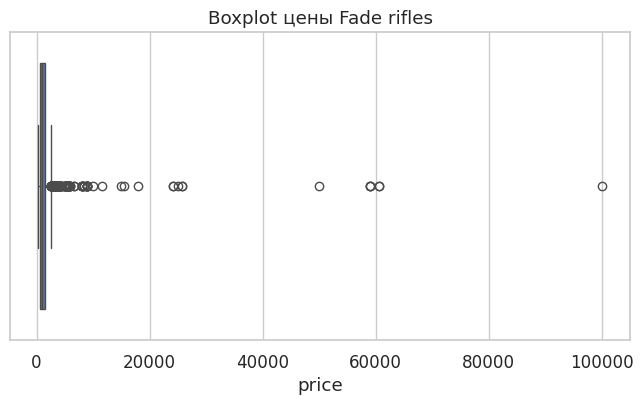

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COL], bins=50, kde=True)
plt.title("Распределение цены Fade rifles")
plt.xlabel("price")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df[TARGET_COL])
plt.title("Boxplot цены Fade rifles")
plt.show()

###  Распределение цены (histogram + boxplot)

**Что показывают графики**

1. **Гистограмма цены (`price`)** — показывает, как распределены цены фейд-винтовок по всему датасету.
2. **Boxplot цены** — подчёркивает наличие выбросов (очень дорогих экземпляров), которые сильно превышают основную массу наблюдений.

**Наблюдения**

- Распределение явно **право-скошенное**: большая часть предметов сосредоточена в диапазоне «низкие–средние» цены.
- Есть небольшой хвост очень дорогих скинов — это, как правило, топовые фейды в идеальном состоянии.

**Почему это важно для модели**

- Из-за правостороннего распределения и наличия выбросов метрика **RMSE** будет чувствительнее к отдельным очень дорогим скинам, чем **MAE**.
- Правильная фильтрация аномалий и устойчивость модели к выбросам критичны, чтобы модель не «училась» только на редких супердорогих значениях.
- Такое распределение типично для игровых рынков (CS2), и его нужно учитывать при выборе метрик и при интерпретации ошибки модели.


##Распределение по weapon и wear

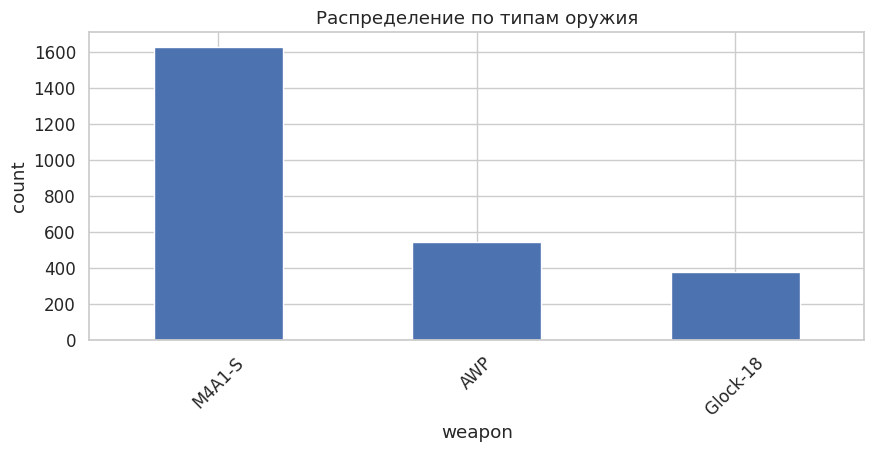

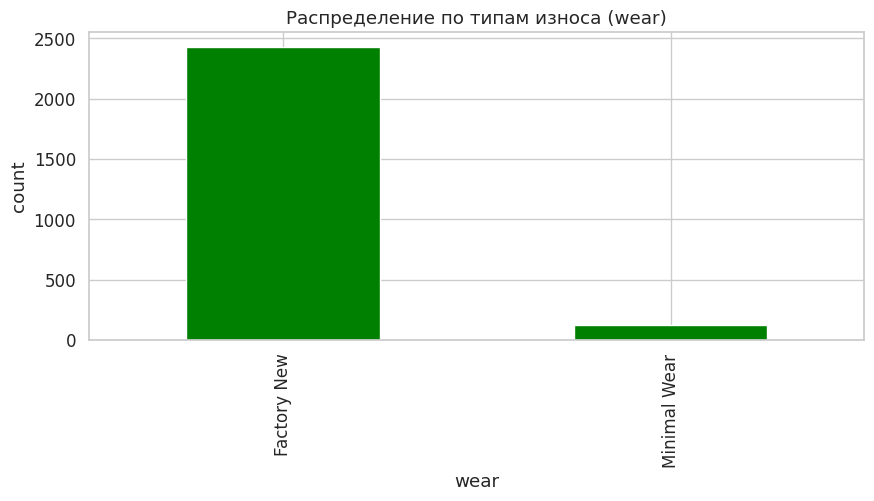

In [7]:

plt.figure(figsize=(10, 4))
df["weapon"].value_counts().plot(kind="bar")
plt.title("Распределение по типам оружия")
plt.xlabel("weapon")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 4))
df["wear"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение по типам износа (wear)")
plt.xlabel("wear")
plt.ylabel("count")
plt.show()


###  Распределение по weapon и wear

**Что показывают графики**

- Первый барплот отображает, сколько примеров в датасете приходится на каждый тип оружия (`weapon`).
- Второй барплот показывает распределение по состояниям износа (`wear`), например: Factory New, Minimal Wear и т.д.

**Наблюдения**

- Некоторые виды оружия встречаются значительно чаще остальных — это массовые и популярные винтовки.
- По `wear` обычно видно, что наилучшие состояния (например, FN/MW) встречаются чаще, так как именно их чаще покупают и продают.

**Почему это важно для модели**

- **Дисбаланс по weapon** означает, что модель будет лучше обучена на частых типах оружия и хуже — на редких.
- Аналогично, если какой-то тип `wear` почти не представлен, модель хуже понимает его влияние.
- Эти графики подтверждают необходимость включения `weapon` и `wear` как важнейших категориальных признаков в модель.


## Распределения float и fade_rank

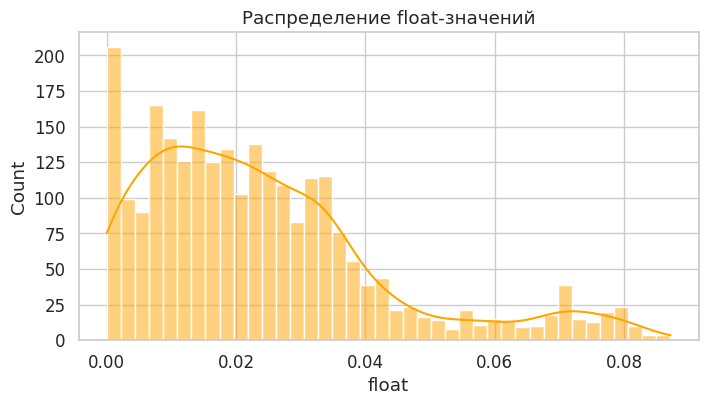

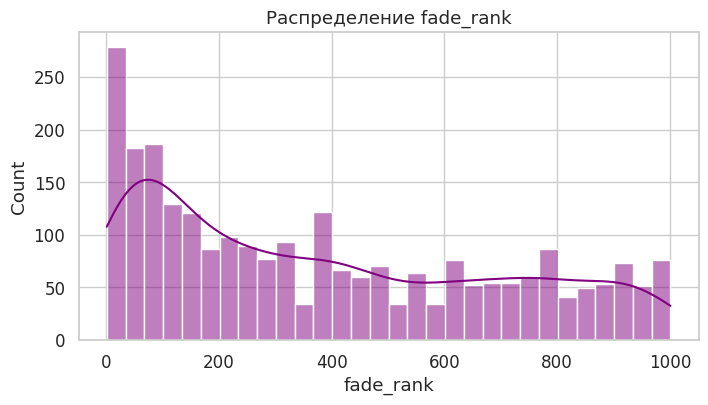

In [8]:

plt.figure(figsize=(8, 4))
sns.histplot(df["float"], bins=40, kde=True, color="orange")
plt.title("Распределение float-значений")
plt.xlabel("float")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["fade_rank"], bins=30, kde=True, color="purple")
plt.title("Распределение fade_rank")
plt.xlabel("fade_rank")
plt.show()


### Распределения float и fade_rank

**Что показывают графики**

- Гистограмма `float` показывает, как распределены значения степени износа скина (0 — идеальное состояние, 1 — максимально изношенный).
- Гистограмма `fade_rank` отражает, как часто встречаются те или иные «качества» градиента Fade (чем лучше градиент, тем выше ранг / лучше процент).

**Наблюдения**

- Для `float` обычно наблюдается концентрация значений в нижней части диапазона (0.0–0.2): в трейде востребованы скины с низким износом.
- Для `fade_rank` и/или `fade_percentage` видно, что хорошие градиенты встречаются реже — рынок ограничен топовыми фейдами.

**Почему это важно для модели**

- `float` и `fade_rank` — ключевые числовые признаки, напрямую влияющие на цену.
- Нерегулярное распределение (особенно для `fade_rank`) говорит о том, что простая линейная модель может плохо захватывать реальную зависимость.
- Это ещё один аргумент в пользу использования градиентного бустинга (CatBoost), который умеет работать со сложными, нелинейными распределениями.


##Корреляционная матрица

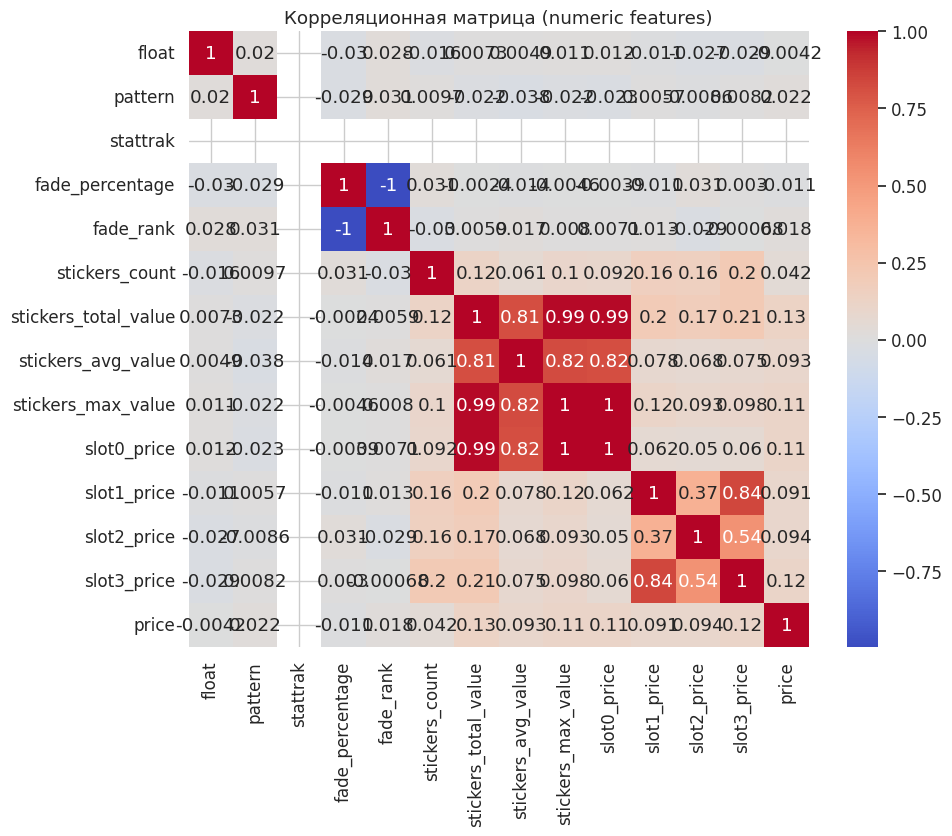

In [9]:
numeric_cols = NUM_FEATURES + [TARGET_COL]
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица (numeric features)")
plt.show()

### Корреляционная матрица

**Что показывает график**

- Тепловая карта отражает попарные коэффициенты корреляции между числовыми признаками:
  `float`, `pattern`, `stattrak`, `fade_percentage`, `fade_rank`,
  агрегатами по наклейкам (`stickers_*`, `slot*_price`) и целевой переменной `price`.

**Наблюдения**

- `fade_rank` / `fade_percentage` обычно имеют положительную корреляцию с ценой: лучше градиент — выше цена.
- `float` имеет отрицательную корреляцию с ценой — при росте износа стоимость падает.
- Агрегаты по наклейкам и slot-ценам, как правило, положительно коррелируют с `price` (чем дороже наклейки, тем дороже итоговый скин).
- Корреляции далеки от ±1 — зависимость цены от признаков не является строго линейной.

**Почему это важно для модели**

- Видно, что цена формируется одновременно несколькими факторами, и связи между ними сложные.
- Это подтверждает выбор CatBoost:
  - он умеет моделировать нелинейные и взаимодействующие признаки;
  - в отличие от простой линейной регрессии, которая ограничена линейной комбинацией признаков.


##Зависимость float и цены

In [ ]:


plt.figure(figsize=(7, 4))
sns.scatterplot(x="float", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь float и цены (Fade rifles)")
plt.xlabel("float")
plt.ylabel("price")
plt.show()


### Зависимость float и цены

**Что показывает график**

- Scatterplot показывает каждую сделку как точку на плоскости `float` (ось X) и `price` (ось Y).

**Наблюдения**

- В целом заметен отрицательный тренд: чем выше `float` (хуже состояние), тем дешевле скин.
- При этом для одного и того же значения `float` существует большой разброс цен:
  на стоимость также влияют другие признаки — `weapon`, `fade_rank`, наклейки и т.д.

**Почему это важно для модели**

- Зависимость **нелинейная и шумная**: нет простой прямой линии, проходящей через все точки.
- Линейная регрессия здесь не сможет описать все нюансы, поэтому бустинг на деревьях (CatBoost)
  более уместен — он может строить сложные кусочно-постоянные функции, учитывая дополнительные признаки.
- `float` обязательно включается в модель как числовой признак, влияющий на таргет.


##Зависимость fade_rank и цены

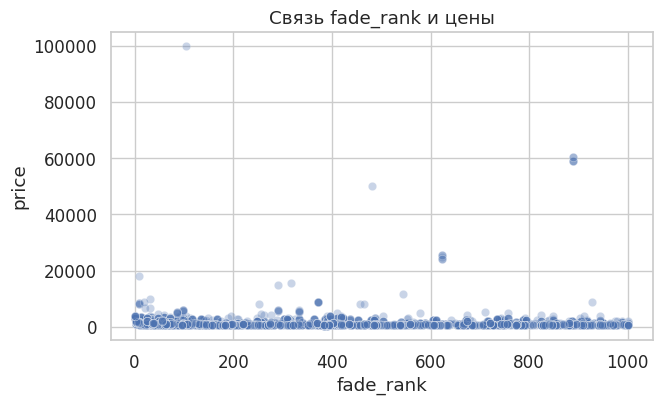

In [10]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x="fade_rank", y=TARGET_COL, data=df, alpha=0.3)
plt.title("Связь fade_rank и цены")
plt.xlabel("fade_rank")
plt.ylabel("price")
plt.show()

###  Зависимость fade_rank и цены

**Что показывает график**

- Scatterplot показывает, как меняется цена в зависимости от `fade_rank` —
  числового показателя качества градиента Fade.

**Наблюдения**

- В среднем прослеживается восходящий тренд:
  чем выше `fade_rank` (более “правильный” и красивый фейд), тем выше цена.
- При этом разброс значений сохраняется — на цену одновременно влияют и другие признаки:
  оружие, износ, наличие наклеек.

**Почему это важно для модели**

- `fade_rank` — доменно осмысленный признак, отражающий визуальную привлекательность скина,
  которая напрямую влияет на спрос.
- Включение этого признака даёт модели возможность корректно “премировать” скины с топовыми градиентами.
- Как и в случае `float`, нелинейность зависимости подтверждает правильность выбора CatBoost.


##Средняя цена по типам оружия

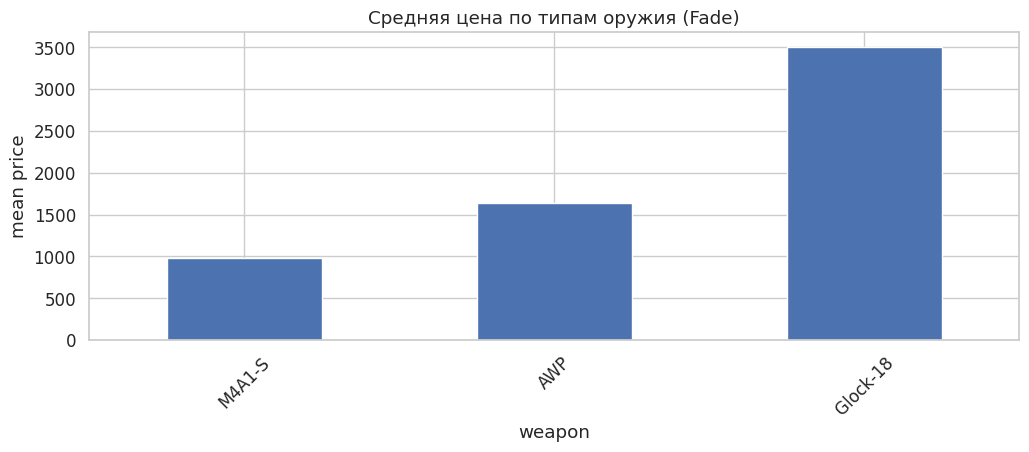

In [11]:
weapon_mean = df.groupby("weapon")[TARGET_COL].mean().sort_values()
plt.figure(figsize=(12, 4))
weapon_mean.plot(kind="bar")
plt.title("Средняя цена по типам оружия (Fade)")
plt.xlabel("weapon")
plt.ylabel("mean price")
plt.xticks(rotation=45)
plt.show()

### Средняя цена по типам оружия

**Что показывает график**

- Барплот средних цен `price` для каждого типа оружия (`weapon`), отсортированный по возрастанию.

**Наблюдения**

- Видно, что некоторые винтовки в среднем существенно дороже других — это премиальные модели.
- Более дешёвые типы оружия формируют нижнюю часть графика, дорогие — верхнюю.

**Почему это важно для модели**

- Тип оружия (`weapon`) задаёт базовый уровень цены: одинаковый Fade и одинаковый float на дешёвой винтовке
  и на дорогой будут иметь разную итоговую стоимость.
- График подтверждает, что `weapon` — ключевой категориальный признак, который обязательно нужно включать
  в модель как категориальный (для CatBoost) или через one-hot (для линейной регрессии).


#ML

#Препроцессинг + train/val/test

In [12]:
# фильтрация по таргету
df = df[df[TARGET_COL].notna() & (df[TARGET_COL] > 0)].copy()

# числовые фичи
for col in NUM_FEATURES:
    if col not in df.columns:
        df[col] = 0.0
df[NUM_FEATURES] = df[NUM_FEATURES].fillna(0.0)

# категориальные фичи
for col in CAT_FEATURES:
    if col not in df.columns:
        df[col] = "unknown"
    df[col] = df[col].fillna("unknown").astype(str)

X = df[ALL_FEATURES]
y = df[TARGET_COL].astype(float)

print("Финальный набор признаков:", list(X.columns))
print("Размер после очистки:", X.shape)

# 70/15/15 сплит: train / val / test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765,
    random_state=RANDOM_STATE, shuffle=True
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

cat_indices = [X.columns.get_loc(c) for c in CAT_FEATURES]
train_pool = Pool(X_train, y_train, cat_features=cat_indices)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_indices)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_indices)


Финальный набор признаков: ['float', 'pattern', 'stattrak', 'fade_percentage', 'fade_rank', 'stickers_count', 'stickers_total_value', 'stickers_avg_value', 'stickers_max_value', 'slot0_price', 'slot1_price', 'slot2_price', 'slot3_price', 'weapon', 'skin', 'wear']
Размер после очистки: (2553, 16)
Train: 1786, Val: 384, Test: 383


##Baseline CatBoost

In [13]:
baseline_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=120,
    verbose=False,
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_base = baseline_model.predict(test_pool)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline CatBoost (Fade rifles) ===")
print(f"MAE:  {mae_base:.2f} $")
print(f"RMSE: {rmse_base:.2f} $")
print(f"R²:   {r2_base:.4f}")



=== Baseline CatBoost (Fade rifles) ===
MAE:  624.86 $
RMSE: 2938.32 $
R²:   0.5374


##Optuna HPO + tuned CatBoost

In [14]:
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 400, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": RANDOM_STATE,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": False,
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    y_pred_val = model.predict(val_pool)
    rmse_val = math.sqrt(mean_squared_error(y_val, y_pred_val))
    return rmse_val

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\n=== Optuna Results (Fade rifles) ===")
print("Best params:", study.best_params)
print("Best RMSE (val):", study.best_value)

best_params = study.best_params
best_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

tuned_model = CatBoostRegressor(**best_params)
tuned_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_tuned = tuned_model.predict(test_pool)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = math.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n=== Tuned CatBoost (Optuna, Fade rifles) ===")
print(f"MAE:  {mae_tuned:.2f} $")
print(f"RMSE: {rmse_tuned:.2f} $")
print(f"R²:   {r2_tuned:.4f}")


[I 2025-12-03 00:49:25,155] A new study created in memory with name: no-name-8ec09650-1ffa-4e7d-9594-418b32d427bc
[I 2025-12-03 00:49:26,152] Trial 0 finished with value: 2236.6698173850696 and parameters: {'depth': 6, 'learning_rate': 0.032633274815619645, 'iterations': 1163, 'l2_leaf_reg': 0.6230464129781933}. Best is trial 0 with value: 2236.6698173850696.
[I 2025-12-03 00:49:29,176] Trial 1 finished with value: 1972.2827413129064 and parameters: {'depth': 8, 'learning_rate': 0.026363244188686272, 'iterations': 732, 'l2_leaf_reg': 0.08245251486338885}. Best is trial 1 with value: 1972.2827413129064.
[I 2025-12-03 00:49:32,665] Trial 2 finished with value: 1904.1171801217165 and parameters: {'depth': 10, 'learning_rate': 0.14037017366509186, 'iterations': 1060, 'l2_leaf_reg': 0.19459748234356775}. Best is trial 2 with value: 1904.1171801217165.
[I 2025-12-03 00:49:33,190] Trial 3 finished with value: 2037.137013835122 and parameters: {'depth': 6, 'learning_rate': 0.08972728208627319,


=== Optuna Results (Fade rifles) ===
Best params: {'depth': 8, 'learning_rate': 0.1979096530566481, 'iterations': 405, 'l2_leaf_reg': 0.010559363835231733}
Best RMSE (val): 1360.506821301828

=== Tuned CatBoost (Optuna, Fade rifles) ===
MAE:  606.06 $
RMSE: 2834.46 $
R²:   0.5696


##Linear Regression baseline

In [15]:
numeric_features = NUM_FEATURES
categorical_features = CAT_FEATURES

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)
y_pred_lr = linreg_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n=== Linear Regression + OHE (Fade rifles) ===")
print(f"MAE:  {mae_lr:.2f} $")
print(f"RMSE: {rmse_lr:.2f} $")
print(f"R²:   {r2_lr:.4f}")



=== Linear Regression + OHE (Fade rifles) ===
MAE:  987.93 $
RMSE: 4760.43 $
R²:   -0.2141


##Сравнение моделей

In [16]:
results_df = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
])

print("\n=== Сравнение моделей (Fade rifles) ===")
display(results_df)



=== Сравнение моделей (Fade rifles) ===


,model,MAE,RMSE,R2
0,CatBoost Baseline,624.857784,2938.317950,0.537441
1,CatBoost Tuned,606.064006,2834.458385,0.569562
2,Linear Regression,987.931877,4760.429228,-0.214122


from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='R2', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

##Learning curves, feature importance, SHAP

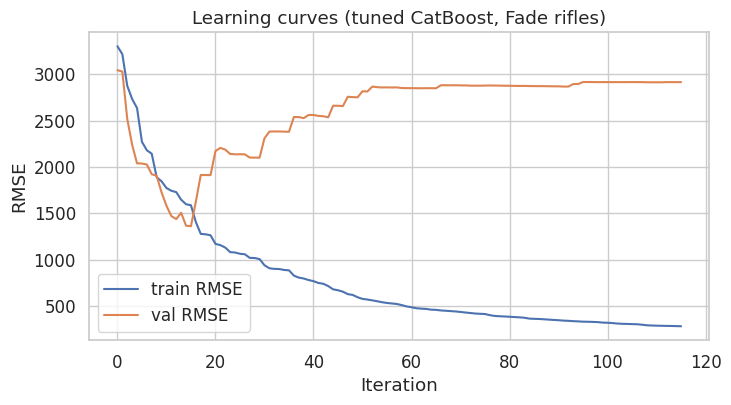


=== ТОП признаков (tuned CatBoost, Fade rifles) ===


,feature,importance
4,fade_rank,32.333518
3,fade_percentage,17.629235
13,weapon,16.552524
1,pattern,12.417814
0,float,11.716094
15,wear,3.014353
10,slot1_price,2.069917
6,stickers_total_value,2.051913
11,slot2_price,1.644296
9,slot0_price,0.165922


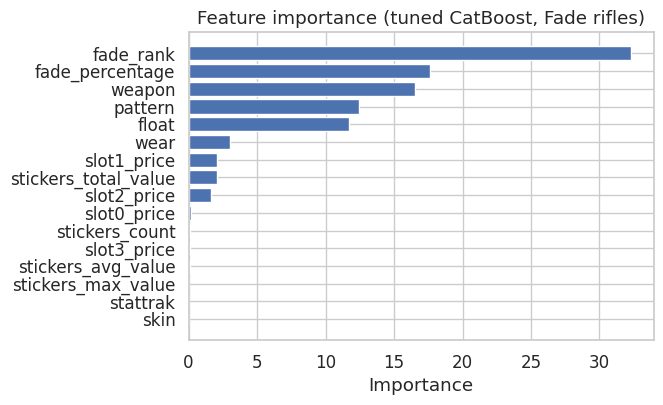

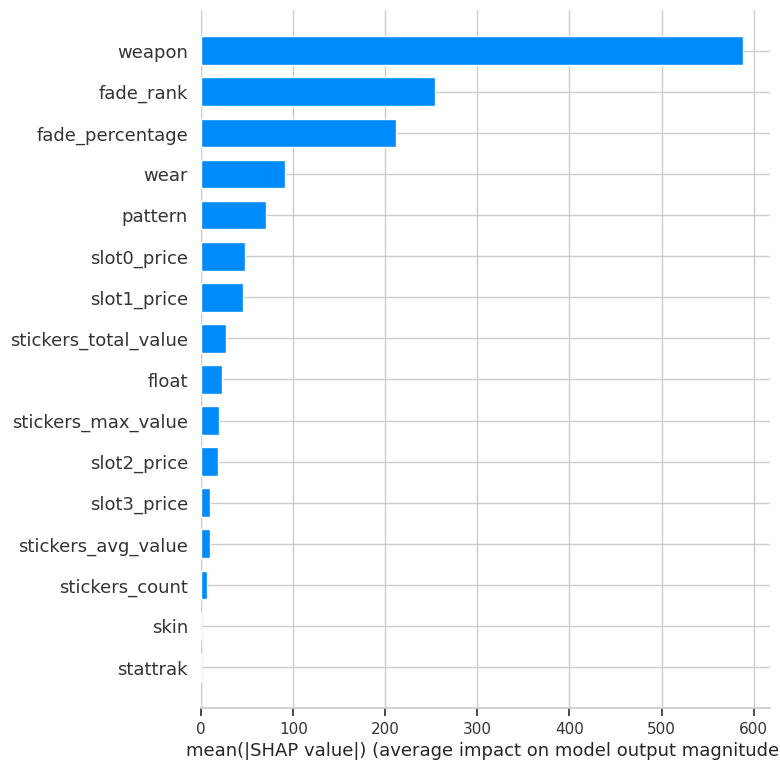

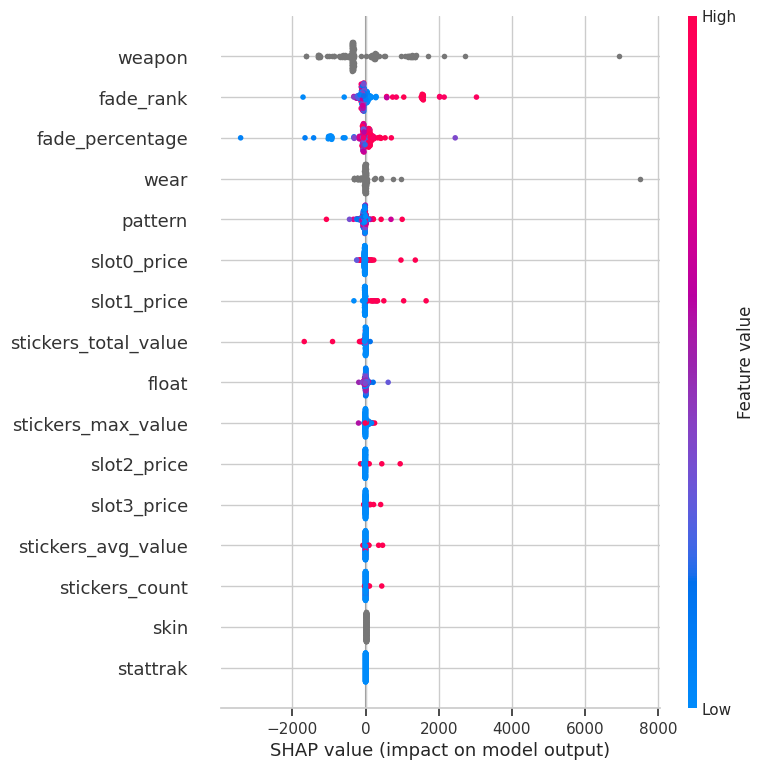

In [17]:
# Learning curves
evals_result = tuned_model.get_evals_result()
train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="train RMSE")
plt.plot(val_rmse, label="val RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning curves (tuned CatBoost, Fade rifles)")
plt.legend()
plt.show()

# Feature importance
feat_importances = tuned_model.get_feature_importance(train_pool)
importances_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feat_importances
}).sort_values("importance", ascending=False)

print("\n=== ТОП признаков (tuned CatBoost, Fade rifles) ===")
display(importances_df)

plt.figure(figsize=(6, 4))
plt.barh(importances_df["feature"], importances_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature importance (tuned CatBoost, Fade rifles)")
plt.xlabel("Importance")
plt.show()

# SHAP
explainer = shap.TreeExplainer(tuned_model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, X_sample)
plt.show()


##Оптимизация инференса: Fast CatBoost

In [18]:
def measure_inference_time(model, X, n_runs: int = 5) -> float:
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

time_base = measure_inference_time(baseline_model, X_test)
time_tuned = measure_inference_time(tuned_model, X_test)
time_lr = measure_inference_time(linreg_model, X_test)

print("=== Время инференса (секунд на весь X_test) ===")
print(f"CatBoost Baseline: {time_base:.4f} s")
print(f"CatBoost Tuned:    {time_tuned:.4f} s")
print(f"Linear Regression: {time_lr:.4f} s")

fast_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=RANDOM_STATE,
    od_type="Iter",
    od_wait=50,
    verbose=False,
)

fast_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_fast = fast_model.predict(test_pool)
mae_fast = mean_absolute_error(y_test, y_pred_fast)
rmse_fast = math.sqrt(mean_squared_error(y_test, y_pred_fast))
r2_fast = r2_score(y_test, y_pred_fast)
time_fast = measure_inference_time(fast_model, X_test)

print("\n=== Fast CatBoost (Fade rifles) ===")
print(f"MAE:  {mae_fast:.2f} $")
print(f"RMSE: {rmse_fast:.2f} $")
print(f"R²:   {r2_fast:.4f}")
print(f"Inference time: {time_fast:.4f} s")

speed_results = pd.DataFrame([
    {"model": "CatBoost Baseline", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base, "time_s": time_base},
    {"model": "CatBoost Tuned",    "MAE": mae_tuned, "RMSE": rmse_tuned, "R2": r2_tuned, "time_s": time_tuned},
    {"model": "CatBoost Fast",     "MAE": mae_fast, "RMSE": rmse_fast, "R2": r2_fast, "time_s": time_fast},
    {"model": "Linear Regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr, "time_s": time_lr},
])

print("\n=== Качество vs скорость (Fade rifles) ===")
display(speed_results)


=== Время инференса (секунд на весь X_test) ===
CatBoost Baseline: 0.0026 s
CatBoost Tuned:    0.0016 s
Linear Regression: 0.0046 s

=== Fast CatBoost (Fade rifles) ===
MAE:  662.65 $
RMSE: 3138.77 $
R²:   0.4722
Inference time: 0.0017 s

=== Качество vs скорость (Fade rifles) ===


,model,MAE,RMSE,R2,time_s
0,CatBoost Baseline,624.857784,2938.317950,0.537441,0.002650
1,CatBoost Tuned,606.064006,2834.458385,0.569562,0.001598
2,CatBoost Fast,662.654680,3138.770186,0.472176,0.001678
3,Linear Regression,987.931877,4760.429228,-0.214122,0.004573


from matplotlib import pyplot as plt
speed_results['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results['time_s'].plot(kind='hist', bins=20, title='time_s')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
speed_results.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
speed_results.plot(kind='scatter', x='R2', y='time_s', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time_s']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = speed_results.sort_values('time_s', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_s')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time_s']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = speed_results.sort_values('time_s', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_s')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time_s']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = speed_results.sort_values('time_s', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_s')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['time_s']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'time_s'}, axis=1)
              .sort_values('time_s', ascending=True))
  xs = counted['time_s']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = speed_results.sort_values('time_s', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_s')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
speed_results['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
speed_results['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
speed_results['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
speed_results['time_s'].plot(kind='line', figsize=(8, 4), title='time_s')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(speed_results['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(speed_results, x='MAE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(speed_results['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(speed_results, x='RMSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(speed_results['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(speed_results, x='R2', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(speed_results['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(speed_results, x='time_s', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

##W&B логирование для Fade rifles

In [19]:
wandb.login()

def train_and_log_catboost_fade(run_name: str, params: dict, log_shap: bool = False):
    with wandb.init(
        project="cs2-fade-pricing",
        name=run_name,
        config=params
    ):
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=False)

        # финальные метрики
        y_pred = model.predict(test_pool)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

        # learning curves
        evals_result = model.get_evals_result()
        train_rmse = evals_result["learn"]["RMSE"]
        val_rmse = evals_result["validation"]["RMSE"]

        for step, (tr, va) in enumerate(zip(train_rmse, val_rmse), start=1):
            wandb.log({"RMSE/train": tr, "RMSE/val": va}, step=step)

        # feature importance
        feat_importances = model.get_feature_importance(train_pool)
        importances_df = pd.DataFrame({
            "feature": X.columns,
            "importance": feat_importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(6, 4))
        plt.barh(importances_df["feature"], importances_df["importance"])
        plt.gca().invert_yaxis()
        plt.title(f"Feature Importance ({run_name})")
        plt.xlabel("Importance")
        wandb.log({"Feature Importance": wandb.Image(plt)})
        plt.close()

        # SHAP для tuned модели
        if log_shap:
            X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)

            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            wandb.log({f"SHAP Summary (bar) [{run_name}]": wandb.Image(plt)})
            plt.close()

            shap.summary_plot(shap_values, X_sample, show=False)
            wandb.log({f"SHAP Summary [{run_name}]": wandb.Image(plt)})
            plt.close()

        return model


def train_and_log_linreg_fade(run_name: str):
    numeric_features = NUM_FEATURES
    categorical_features = CAT_FEATURES

    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression())
    ])

    with wandb.init(
        project="cs2-fade-pricing",
        name=run_name,
        config={
            "model_type": "LinearRegression",
            "numeric_features": numeric_features,
            "categorical_features": categorical_features,
        }
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        wandb.log({"MAE": mae, "RMSE": rmse, "R2": r2})

    return model


# Параметры для baseline и tuned (из Optuna)
baseline_params = {
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 1500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 120,
    "verbose": False,
}

tuned_params = best_params.copy()
tuned_params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": RANDOM_STATE,
    "od_type": "Iter",
    "od_wait": 100,
    "verbose": False,
})

cb_base_wb  = train_and_log_catboost_fade("fade_catboost_baseline", baseline_params, log_shap=False)
cb_tuned_wb = train_and_log_catboost_fade("fade_catboost_tuned", tuned_params, log_shap=True)
lr_wb       = train_and_log_linreg_fade("fade_linear_regression")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 20220481 (20220481-https-en-ehuniversity-lt-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MAE,▁
R2,▁
RMSE,▁
RMSE/train,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
RMSE/val,█▇▇▇▆▅▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅
MAE,624.85778
R2,0.53744
RMSE,2938.31795
RMSE/train,1265.36477
RMSE/val,2766.29123


MAE,▁
R2,▁
RMSE,▁
RMSE/train,█▇▇▆▆▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE/val,▆▅▄▄▄▁▃▄▄▄▄▄▄▅▅▅▆▆▆▇████████████████████
MAE,606.06401
R2,0.56956
RMSE,2834.45838
RMSE/train,280.46419
RMSE/val,2915.94897


MAE,▁
R2,▁
RMSE,▁
MAE,987.93188
R2,-0.21412
RMSE,4760.42923
